In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(os.environ["CUDA_VISIBLE_DEVICES"],torch.cuda.device_count(), torch.cuda.current_device())

2 1 0


In [2]:
import os
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import optim
# from utils import *
# from modules import UNet
import logging
from torch.utils.tensorboard import SummaryWriter

import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torch import optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import math

print(torch.__version__)
torch.cuda.is_available()

import h5py


1.12.0+cu102


In [3]:
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=[32, 16, 16], device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    # def sample(self, model, n):
    #     logging.info(f"Sampling {n} new images....")
    #     model.eval()
    #     with torch.no_grad():
    #         x = torch.randn((n, self.img_size[0], self.img_size[1],self.img_size[2])).to(self.device)
    #         for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
    #             t = (torch.ones(n) * i).long().to(self.device)
    #             predicted_noise = model(x, t)
    #             alpha = self.alpha[t][:, None, None, None]
    #             alpha_hat = self.alpha_hat[t][:, None, None, None]
    #             beta = self.beta[t][:, None, None, None]
    #             if i > 1:
    #                 noise = torch.randn_like(x)
    #             else:
    #                 noise = torch.zeros_like(x)
    #             x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
    #     model.train()
    #     # x = (x.clamp(-1, 1) + 1) / 2
    #     # x = x.clamp(min=0)
    #     # x = (x * 255).type(torch.uint8)
    #     return x
    
    def sample(self, model, n, labels, cfg_scale=3):
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, self.img_size[0], self.img_size[1],self.img_size[2])).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, labels)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        # x = (x.clamp(-1, 1) + 1) / 2
        # x = (x * 255).type(torch.uint8)
        # x = x.clamp(0, 1)
        # x = torch.softmax(x,dim=1)
        return x

In [4]:
is_wandb = True
if is_wandb:
    import wandb
    wandb.init(project="diff_protein_gen", entity="jathurshan_0330")
    wandb.run.name = "Alphafold_Distogram_generation(Diffusion)_conditioned_on_SSE"
    wandb.run.save()
    # "Finetuning only classification head Ki67 using SIMCLR Pretrained Model"
    exp_path = f"./model_checkpoints/{wandb.run.name}"
    if not os.path.exists(exp_path):
        os.mkdir(exp_path)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jathurshan_0330. Use `wandb login --relogin` to force relogin
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.




wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


## Data Loading

In [5]:
file_list = glob.glob("/ssd/Protein_extracted_data_AF/*.h5")
file_list.sort()
print(len(file_list))


new_list = []
for i in file_list:
    with h5py.File(i, "r") as f:
            # dist_ref = np.array(f.get('dist_ref'))
            sse = np.array(f.get('sse'))
            # seq = np.array(f.get('seq'))
            # mask = np.array(f.get('mask'))
            f.close()
    if len(sse.shape)!=0:
        if sse.shape[-1]!=0:
            new_list.append(i)
print(len(new_list))#,error_list)


c = 0
max_value = 0
min_value = 100000

# for i in new_list:
#     with h5py.File(i, "r") as f:
#             dist_ref = np.expand_dims(np.array(f.get('dist_ref')),axis=0)
#     if dist_ref.max()>max_value:
#         max_value = dist_ref.max()
#     if dist_ref.min()<min_value:
#         min_value = dist_ref.min()
# print(min_value,max_value)

9058
6109


In [6]:
#15051
file_list = new_list#glob.glob("/home/jupyter-jathurshan/Protein_extracted_data/*.h5")
# file_list.sort()
# print(len(file_list))

train_file_list = file_list[:int(len(file_list)*0.8)]
val_file_list = file_list[int(len(file_list)*0.8):int(len(file_list)*0.9)]
test_file_list = file_list[int(len(file_list)*0.9):]

print(len(train_file_list),len(val_file_list),len(test_file_list))

4887 611 611


In [7]:
def plot_sub_plots(rows,columns,img_list,title_list,cmap = 'inferno'):
    fig, axs = plt.subplots(rows, columns, figsize = (columns*10,rows*10))
    if rows == 1:
        for i in range(len(img_list)):
            im1 = axs[i].imshow(img_list[i],cmap=cmap)
            axs[i].set_title(f"{title_list[i]}")
            plt.colorbar(im1, ax=axs[i])#,shrink = 0.3
    else:
        for i in range(len(img_list)):
            im1 = axs[i//columns][i%columns].imshow(img_list[i],cmap=cmap)
            axs[i//columns][i%columns].set_title(f"{title_list[i]}")
            plt.colorbar(im1, ax=axs[i//columns][i%columns])#,shrink = 0.3)
    # plt.show()
    return fig


## Dist ref

In [60]:
import h5py
### Using Distant Ref
class Protein_Dataset(Dataset):
    def __init__(self,file_list, device,pro_len = 64):
      
        self.file_list = file_list
        self.pro_len = pro_len
        self.device = device
        
        self.device = device
        
        print(f"Data_size : {len(self.file_list)}") 
        
    def __len__(self):
        return len(self.file_list )

    def __getitem__(self, idx):
        
        with h5py.File(self.file_list[idx], "r") as f:
            dist_ref = np.array(f.get('dist_ref'))
            dist_ref[np.isnan(dist_ref)] = 0
            sse = np.array(f.get('sse'))
            # seq = np.array(f.get('seq'))
            mask = np.array(f.get('mask'))
            f.close()
        
       
        
        dist_ref = torch.from_numpy(dist_ref).unsqueeze(0).clamp(max=50)
        dist_ref =dist_ref/50
        sse = torch.from_numpy(sse).unsqueeze(0).float()
        # seq = np.array(f.get('seq'))
        mask = torch.from_numpy(mask).squeeze().unsqueeze(0)
        ref_len = dist_ref.shape[-1]
        # print(self.file_list[idx],dist_ref.shape,sse.shape)
        
        # print(self.file_list[idx],dist_ref.shape,mask.shape,sse.shape)
        
#         if dist_ref.shape[-1]<self.pro_len:
#             pad = ((self.pro_len-dist_ref.shape[-1])//2,(self.pro_len-dist_ref.shape[-1])//2,(self.pro_len-dist_ref.shape[-1])//2,(self.pro_len-dist_ref.shape[-1])//2)
#             dist_ref =  F.pad(dist_ref, pad, mode='reflect')
#             mask =  F.pad(mask, pad, mode='constant')
            
#             pad = ((self.pro_len-sse.shape[-1])//2,(self.pro_len-sse.shape[-1])//2)
#             sse =  F.pad(sse, pad, mode='reflect')
#         elif dist_ref.shape[-1]>self.pro_len:
#             crop = transforms.CenterCrop(self.pro_len)
#             dist_ref = crop(dist_ref)
#             mask = crop(mask)
#             crop = transforms.CenterCrop((3,self.pro_len))
#             sse = crop(sse)
         
        if dist_ref.shape[-1]!=self.pro_len:
            crop = transforms.CenterCrop(self.pro_len)
            dist_ref = crop(dist_ref)
            mask = crop(mask)
            crop = transforms.CenterCrop((3,self.pro_len))
            sse = crop(sse)
           
        
#         
        return dist_ref.to(self.device).float(), mask.to(self.device).float(), sse.to(self.device).float(),ref_len

## Disto binned

In [8]:
import h5py
### Using Distant binned
def mtx2bins(x_ref, start, end, nbins, mask):
    bins = np.linspace(start, end, nbins)
    x_true = np.digitize(x_ref, bins).astype(np.uint8)
    x_true[mask] = 0
    return np.eye(nbins+1)[x_true][...,:-1]
class Protein_Dataset(Dataset):
    def __init__(self,file_list, device,pro_len = 64):
      
        self.file_list = file_list
        self.pro_len = pro_len
        self.device = device
        
        self.device = device
        
        print(f"Data_size : {len(self.file_list)}") 
        
    def __len__(self):
        return len(self.file_list )

    def __getitem__(self, idx):
        
        with h5py.File(self.file_list[idx], "r") as f:
            dist_ref = np.array(f.get('p_dist_af'))
            dist_ref[np.isnan(dist_ref)] = 0
            sse = np.array(f.get('sse'))
            # seq = np.array(f.get('seq'))
            mask = np.array(f.get('mask'))
            f.close()
        
       
        
        # dist_ref = torch.from_numpy(dist_ref).unsqueeze(0)#.clamp(max=50)
        # dist_ref =dist_ref/50
        dist_ref  = torch.moveaxis(torch.from_numpy(dist_ref),-1,0)
        # print(dist_ref.shape)
        sse = torch.from_numpy(sse).unsqueeze(0).float()
        # seq = np.array(f.get('seq'))
        mask = torch.from_numpy(mask).squeeze().unsqueeze(0)
        ref_len = dist_ref.shape[-1]
    
         
        if dist_ref.shape[-1]!=self.pro_len:
            crop = transforms.CenterCrop(self.pro_len)
            dist_ref = crop(dist_ref)
            mask = crop(mask)
            crop = transforms.CenterCrop((3,self.pro_len))
            sse = crop(sse)
           
        
#         
        return dist_ref.to(self.device).float(), mask.to(self.device).float(), sse.to(self.device).float(),ref_len

In [9]:
train_dataset = Protein_Dataset(train_file_list, device = device) 
val_dataset = Protein_Dataset(val_file_list, device = device)

Data_size : 4887
Data_size : 611


In [10]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

torch.Size([32, 39, 64, 64]) torch.Size([32, 1, 64, 64]) torch.Size([32, 1, 3, 64]) tensor([278, 249, 129, 492, 123, 235, 274, 212,  70, 138, 152, 152, 501, 356,
        178, 431, 313, 346,  98, 148,  54, 251, 469, 342, 377, 278, 309, 585,
        146, 778,  76, 319])



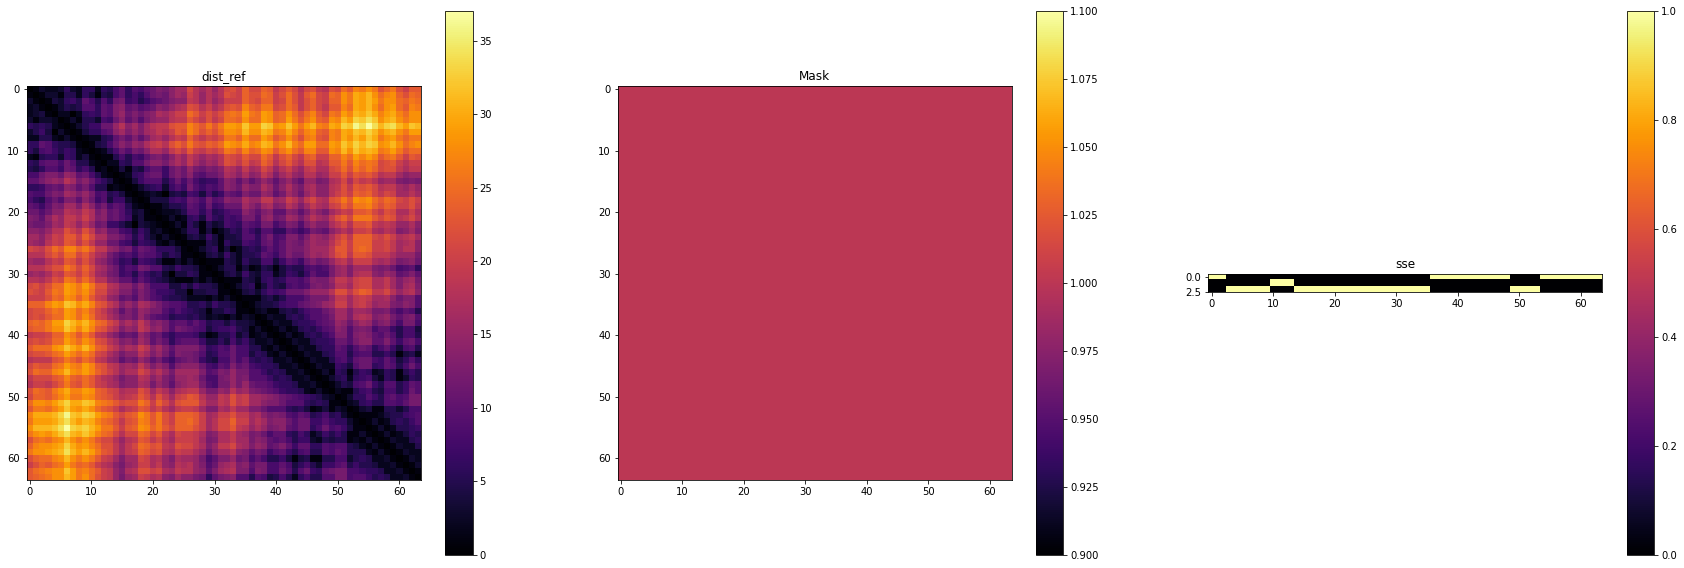

In [11]:
dist_ref,mask,sse,ref_len   = next(iter(train_data_loader))

print(dist_ref.shape,mask.shape,sse.shape,ref_len) 
ind = 0
img_list = [dist_ref[ind].argmax(0).squeeze().detach().cpu().numpy(),
           mask[ind].squeeze().detach().cpu().numpy(),
           sse[ind].squeeze().detach().cpu().numpy(),
           ]

title_list = ['dist_ref','Mask','sse']
plot_sub_plots(1,3,img_list,title_list,cmap = 'inferno')
print('')

## Autoencoder Model

In [12]:
class CNN_Encoder(nn.Module):
    
    def __init__(self, input_nc=1, ngf = 16):
        super(CNN_Encoder, self).__init__()
        self.enc1 = self.enc_block(in_ch = input_nc, out_ch = ngf, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        self.enc2 = self.enc_block(in_ch = ngf, out_ch = ngf*2, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        # self.enc3 = self.enc_block(in_ch = ngf*2, out_ch = ngf*4, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        # self.enc4 = self.enc_block(in_ch = ngf*4, out_ch = ngf*8, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        # self.enc5 = self.enc_block(in_ch = ngf*8, out_ch = ngf*16, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        
        
    def enc_block(self, in_ch, out_ch, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size,stride=stride, padding=padding, bias=bias),
                # nn.ReLU()
                )
      
            
    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        # x = self.enc3(x)
        # x = self.enc4(x)
        # x = self.enc5(x)
        return x
    

class CNN_Decoder(nn.Module):
    
    def __init__(self, lat_chan=128,out_ch = 1, ngf = 16 ):
        super(CNN_Decoder, self).__init__()
        self.dec1 = self.conv_up_block(in_ch = lat_chan , out_ch = ngf*8, 
                                       kernel_size=4, stride=2, padding = 1,bias = True)
        self.dec2 = self.conv_up_block(in_ch = ngf*8 , out_ch = out_ch, 
                                       kernel_size=4, stride=2, padding = 1,bias = True)
        # self.dec3 = self.conv_up_block(in_ch = ngf*4 , out_ch = ngf*2, 
        #                                kernel_size=4, stride=2, padding = 1,bias = True)
        # self.dec4 = self.conv_up_block(in_ch = ngf*2 , out_ch = 1, 
        #                                kernel_size=4, stride=2, padding = 1,bias = True)
        # self.dec5 = self.conv_up_block(in_ch = ngf , out_ch = 1, 
                                       # kernel_size=4, stride=2, padding = 1,bias = True)
        # self.final = nn.Linear(16,out_ch)
        
        
    def conv_up_block(self,  in_ch, out_ch, kernel_size=4, stride=2, padding = 1,bias = True,outermost = False):
            return nn.Sequential(
                nn.ConvTranspose2d( in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding = padding,bias = bias),
                # nn.ReLU()
                )
        
    def forward(self,x): 
        x = self.dec1(x)
        
        x = self.dec2(x)
        
        
#         x = self.dec3(x)
        
#         x = self.dec4(x)
        # x = self.dec5(x)
        # x = self.final(x)
        # x = torch.moveaxis(x,-1,1)
        return x

In [13]:
####Autoencoder Training Using Binned Distograms Masked loss
enc_path = f'./model_checkpoints/Autoencoder Training Using Distogram in AF bins/encoder_dist.pth.tar'

### Disto ref autoencoder
# enc_path = f'./model_checkpoints/Autoencoder Training Using Distoref/encoder_dist.pth.tar'
encoder = torch.load(enc_path).to(device)#CNN_Encoder(ngf = 16).to(device)#torch.load(enc_path).to(device)
encoder.eval()
print(sum([np.prod(p.size()) for p in encoder.parameters()]))

####Autoencoder Training Using Binned Distograms Masked loss
dec_path = f'./model_checkpoints/Autoencoder Training Using Distogram in AF bins/decoder_dist.pth.tar'
### Disto ref autoencoder
# dec_path = f'./model_checkpoints/Autoencoder Training Using Distoref/decoder_dist.pth.tar'
decoder = torch.load(dec_path).to(device)#CNN_Decoder(lat_chan=32).to(device)#torch.load(dec_path).to(device)
decoder.eval()
print(sum([np.prod(p.size()) for p in decoder.parameters()]))

18224
145575


## Encoder SSE

In [14]:
class CNN_1D_Encoder(nn.Module):
    
    def __init__(self, input_nc=3, ngf = 16):
        super(CNN_1D_Encoder, self).__init__()
        self.enc1 = self.enc_block(in_ch = input_nc, out_ch = ngf, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        self.enc2 = self.enc_block(in_ch = ngf, out_ch = ngf*2, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        self.enc3 = self.enc_block(in_ch = ngf*2, out_ch = ngf*4, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        self.enc4 = self.enc_block(in_ch = ngf*4, out_ch = ngf*8, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        self.enc5 = self.enc_block(in_ch = ngf*8, out_ch = ngf*16, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        self.enc6 = self.enc_block(in_ch = ngf*16, out_ch = ngf*32, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )

        
    def enc_block(self, in_ch, out_ch, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False):
            return nn.Sequential(
                nn.Conv1d(in_ch, out_ch, kernel_size=kernel_size,stride=stride, padding=padding, bias=bias),
                # nn.ReLU()
                )
      
            
    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.enc3(x)
        x = self.enc4(x)
        x = self.enc5(x)
        x = self.enc6(x)
        return x
    



In [15]:
enc_sse_path = f'./model_checkpoints/Autoencoder Training Using SSE/encoder_sse.pth.tar'
encoder_sse = torch.load(enc_sse_path).to(device)#CNN_Encoder(ngf = 16).to(device)#torch.load(enc_path).to(device)
encoder_sse.eval()
print(sum([np.prod(p.size()) for p in encoder.parameters()]))

18224


## UNet

In [16]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())


class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 8)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 4)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 2)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 4)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 8)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 16)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        # print(f"x2: {x2.shape}")
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        # print(f"x3: {x3.shape}")
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        # print(f"x4: {x4.shape}")
        x4 = self.sa3(x4)
        
        # print(f"x4: {x4.shape}")
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)
        
        # print(f"x4: {x4.shape}")
        x = self.up1(x4, x3, t)
        # print(f"x: {x.shape}")
        x = self.sa4(x)
        # print(f"x: {x.shape}")
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output
    
    
class UNet_Conditional(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):#,num_classes = None):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 8)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 4)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 2)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 4)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 8)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 16)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)
        
#         if num_classes is not None:
#             self.label_emb = nn.Embedding(num_classes, time_dim)
        

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t,labels):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)
        # print(f"t:{t.shape}")
        if labels!=None:
            # print(self.label_emb(labels).shape)
            t = t+ labels
        
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        # print(f"x2: {x2.shape}")
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        # print(f"x3: {x3.shape}")
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        # print(f"x4: {x4.shape}")
        x4 = self.sa3(x4)
        
        # print(f"x4: {x4.shape}")
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)
        
        # print(f"x4: {x4.shape}")
        x = self.up1(x4, x3, t)
        # print(f"x: {x.shape}")
        x = self.sa4(x)
        # print(f"x: {x.shape}")
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

In [70]:
# model = UNet_Conditional(c_in=32, c_out=32, time_dim=256, device="cuda").to(device)
model = torch.load("./model_checkpoints/Dist_binned_generation(Diffusion)_conditioned_SSE_continued/u_net_diff_checkpoint.pth.tar").to(device)
# cond_enc = Cond_Encoder().to(device)
#testing
dist_ref,mask,sse,ref_len   = next(iter(train_data_loader))
# print(digit_labels.shape)

lat_c = encoder(dist_ref)
t = torch.randint(low=1, high=1000, size=(dist_ref.shape[0],)).to(device)
labels = encoder_sse(sse.squeeze(1))
print(lat_c.shape,t.shape,labels.shape)

denoised_lat_c = model(lat_c,t,labels.squeeze(-1))

print(denoised_lat_c.shape)

torch.Size([32, 32, 16, 16]) torch.Size([32]) torch.Size([32, 256, 1])
torch.Size([32, 32, 16, 16])


## Training

In [71]:
# optimizer = optim.AdamW(list(model.parameters())+list(cond_enc.parameters()), lr=3e-4)
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
mse = nn.MSELoss()
diffusion = Diffusion(img_size=[32,16,16], device=device)

In [72]:
def recon_loss(x_hat,x):
    criterion = nn.L1Loss()
    return criterion(x_hat,x)

def recon_loss_binned(x_hat,x):
    criterion = nn.CrossEntropyLoss()
    return criterion(x_hat,x)
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count if self.count != 0 else 0
        
def plot_sub_plots(rows,columns,img_list,title_list,cmap = 'inferno'):
    fig, axs = plt.subplots(rows, columns, figsize = (columns*10,rows*10))
    if rows == 1:
        for i in range(len(img_list)):
            im1 = axs[i].imshow(img_list[i],cmap=cmap)
            axs[i].set_title(f"{title_list[i]}")
            plt.colorbar(im1, ax=axs[i])#,shrink = 0.3
    else:
        for i in range(len(img_list)):
            im1 = axs[i//columns][i%columns].imshow(img_list[i],cmap=cmap)
            axs[i//columns][i%columns].set_title(f"{title_list[i]}")
            plt.colorbar(im1, ax=axs[i//columns][i%columns])#,shrink = 0.3)
    # plt.show()
    return fig

In [73]:
def train(model,diffusion,encoder,decoder,encoder_sse,optimizer,data_loader,is_wandb=False,verbose_freq = 500,is_verbose = False):
    encoder.eval()
    decoder.eval()
    encoder_sse.eval()
    model.train()
    # cond_enc.train()
    train_losses = AverageMeter()
    for batch_idx, (x,m,sse,_ ) in enumerate(data_loader):
        x = encoder(x) #x*m
        labels = encoder_sse(sse.squeeze(1))
        
        t = diffusion.sample_timesteps(x.shape[0]).to(device)
        x_t, noise = diffusion.noise_images(x, t)
        predicted_noise = model(x_t, t,labels.squeeze(-1))
        
        loss = mse(noise, predicted_noise) 
        # loss+= recon_loss_binned(x_hat*m,(x.argmax(1).unsqueeze(1)*m).squeeze().type(torch.cuda.LongTensor)) 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # break
        train_losses.update(loss.data.item())
        if is_wandb:
            wandb.log({"batch_loss": loss.data.item()})
    
    
    if is_wandb:
            wandb.log({"train_epoch_loss": train_losses.avg})
            
    if is_verbose:
        print(f"Training Epoch Loss: {train_losses.avg}")
    
    x,m,sse,ref_len   = next(iter(data_loader))
    labels = encoder_sse(sse.squeeze(1))
    
    sampled_images = diffusion.sample(model, n=x.shape[0],labels = labels.squeeze(-1))
    sampled_images = decoder(sampled_images.float())#.clamp(min=0,max=1)
    sampled_images = sampled_images.argmax(1).squeeze().detach().cpu().numpy()
    print(sampled_images.shape)
    sse = sse.squeeze().detach().cpu().numpy()
    x = x.argmax(1).squeeze().detach().cpu().numpy()
    img_list = [sampled_images[0],sse[0],x[0],sampled_images[1],sse[1],x[1],
                sampled_images[2],sse[2],x[2],sampled_images[3],sse[3],x[3],
                sampled_images[4],sse[4],x[4],sampled_images[5],sse[5],x[5],
                sampled_images[6],sse[6],x[6],sampled_images[7],sse[7],x[7],
               ] 
    
    title_list = [ref_len[0].item(),ref_len[0].item(),ref_len[0].item(),ref_len[1].item(),ref_len[1].item(),ref_len[1].item(),
                  ref_len[2].item(),ref_len[2].item(),ref_len[2].item(),ref_len[3].item(),ref_len[3].item(),ref_len[3].item(),
                  ref_len[4].item(),ref_len[4].item(),ref_len[4].item(),ref_len[5].item(),ref_len[5].item(),ref_len[5].item(),
                  ref_len[6].item(),ref_len[6].item(),ref_len[6].item(),ref_len[7].item(),ref_len[7].item(),ref_len[7].item(),]
    
    fig = plot_sub_plots(4,6,img_list,title_list,cmap = 'inferno')
    if is_wandb:
            wandb.log({"examples": wandb.Image(fig)})
    
    return train_losses.avg





    # sampled_images = diffusion.sample(model, n=images.shape[0])
    # save_images(sampled_images, os.path.join("results", args.run_name, f"{epoch}.jpg"))
    # torch.save(model.state_dict(), os.path.join("models", args.run_name, f"ckpt.pt"))


In [ ]:
best_loss = 10000000
train_loss_list = []
n_epochs = 5000

# if not os.path.exists(exp_path):
#     os.mkdir(exp_path)
# print("Training ", end='')
for epoch_idx in range(n_epochs):
    # print('=', end='')
    
    train_loss = train(model,diffusion,encoder,decoder,encoder_sse,optimizer,train_data_loader,is_wandb=is_wandb)     

    train_loss_list.append(train_loss)
    
    
    print(f"Epoch {epoch_idx+1}: {train_loss} ")
    if (train_loss < best_loss): 
        best_loss = train_loss
        # print("Saving Best Model =======================================>")
        torch.save(model, f'{exp_path}/u_net_diff_best_loss.pth.tar')
        # torch.save(cond_enc, f'{exp_path}/cond_enc_diff.pth.tar')
    if (epoch_idx+1)%10 == 0:
        torch.save(model, f'{exp_path}/u_net_diff_checkpoint.pth.tar')
                       
torch.save(model, f'{exp_path}/u_net_diff_final.pth.tar')    
print('Training Completed')

999it [00:16, 61.98it/s]


(32, 64, 64)
Epoch 1: 0.2285904768036633 


999it [00:16, 62.25it/s]


(32, 64, 64)
Epoch 2: 0.22278258252919206 


999it [00:16, 61.79it/s]


(32, 64, 64)
Epoch 3: 0.22671711117756077 


999it [00:16, 61.58it/s]


(32, 64, 64)
Epoch 4: 0.2194294002724857 


999it [00:16, 62.29it/s]


(32, 64, 64)
Epoch 5: 0.21864304297823248 


999it [00:16, 61.90it/s]


(32, 64, 64)
Epoch 6: 0.22481330405405867 


999it [00:15, 62.53it/s]


(32, 64, 64)
Epoch 7: 0.2264921428953729 


999it [00:16, 62.01it/s]


(32, 64, 64)
Epoch 8: 0.22420509632040814 


999it [00:16, 61.76it/s]


(32, 64, 64)
Epoch 9: 0.22534578626717977 


999it [00:16, 62.39it/s]


(32, 64, 64)
Epoch 10: 0.2224499726198553 


999it [00:16, 62.15it/s]


(32, 64, 64)
Epoch 11: 0.22285515457634034 


999it [00:16, 62.05it/s]


(32, 64, 64)
Epoch 12: 0.22677253501686623 


999it [00:16, 62.12it/s]


(32, 64, 64)
Epoch 13: 0.21660993884249433 


999it [00:16, 62.14it/s]


(32, 64, 64)
Epoch 14: 0.22271800380412157 


999it [00:16, 62.39it/s]


(32, 64, 64)
Epoch 15: 0.22236300423377897 


999it [00:16, 62.00it/s]


(32, 64, 64)
Epoch 16: 0.21968587590911523 


999it [00:16, 62.15it/s]


(32, 64, 64)
Epoch 17: 0.22047328355351115 


999it [00:16, 61.92it/s]


(32, 64, 64)
Epoch 18: 0.21885784963766733 


999it [00:16, 61.81it/s]


(32, 64, 64)
Epoch 19: 0.2255882631714751 


999it [00:16, 62.28it/s]


(32, 64, 64)
Epoch 20: 0.2179985093634303 


999it [00:16, 62.03it/s]
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(32, 64, 64)
Epoch 21: 0.22304854717681077 


999it [00:16, 62.37it/s]


(32, 64, 64)
Epoch 22: 0.22399427263232752 


999it [00:16, 62.00it/s]


(32, 64, 64)
Epoch 23: 0.21984291415873583 


999it [00:16, 62.16it/s]


(32, 64, 64)
Epoch 24: 0.2194137476324066 


999it [00:16, 62.34it/s]


(32, 64, 64)
Epoch 25: 0.22286519299193128 


999it [00:16, 62.41it/s]


(32, 64, 64)
Epoch 26: 0.22097475499641606 


999it [00:16, 62.19it/s]


(32, 64, 64)
Epoch 27: 0.21905819902090523 


999it [00:16, 62.20it/s]


(32, 64, 64)
Epoch 28: 0.22184285533622028 


999it [00:16, 62.27it/s]


(32, 64, 64)
Epoch 29: 0.2234044041696603 


999it [00:16, 62.05it/s]


(32, 64, 64)
Epoch 30: 0.2185496832054805 


999it [00:16, 62.00it/s]


(32, 64, 64)
Epoch 31: 0.21607246643644037 


999it [00:16, 62.12it/s]


(32, 64, 64)
Epoch 32: 0.22238793290727507 


999it [00:16, 61.54it/s]


(32, 64, 64)
Epoch 33: 0.2240449976388032 


999it [00:16, 62.14it/s]


(32, 64, 64)
Epoch 34: 0.22338567141110335 


999it [00:16, 62.24it/s]


(32, 64, 64)
Epoch 35: 0.21782571743658888 


999it [00:16, 61.90it/s]


(32, 64, 64)
Epoch 36: 0.22112511183188213 


999it [00:16, 62.24it/s]


(32, 64, 64)
Epoch 37: 0.2198822103985926 


999it [00:16, 61.83it/s]


(32, 64, 64)
Epoch 38: 0.2233784373213605 


999it [00:16, 62.14it/s]


(32, 64, 64)
Epoch 39: 0.21790639523083602 


999it [00:16, 62.09it/s]


(32, 64, 64)
Epoch 40: 0.2123555740932139 


999it [00:16, 61.98it/s]


(32, 64, 64)
Epoch 41: 0.21991281356753373 


999it [00:16, 61.78it/s]


(32, 64, 64)
Epoch 42: 0.22571461520543912 


999it [00:16, 61.99it/s]


(32, 64, 64)
Epoch 43: 0.22334051053456175 


999it [00:16, 62.31it/s]


(32, 64, 64)
Epoch 44: 0.22072653121095362 


999it [00:16, 61.87it/s]


(32, 64, 64)
Epoch 45: 0.2188745660752785 


999it [00:16, 61.95it/s]


(32, 64, 64)
Epoch 46: 0.21993268808213676 


999it [00:16, 62.39it/s]


(32, 64, 64)
Epoch 47: 0.2242458978198408 


999it [00:16, 61.53it/s]


(32, 64, 64)
Epoch 48: 0.22000581413749756 


999it [00:16, 62.25it/s]


(32, 64, 64)
Epoch 49: 0.22672295752095012 


999it [00:16, 62.17it/s]


(32, 64, 64)
Epoch 50: 0.22240861159999195 


999it [00:16, 61.76it/s]


(32, 64, 64)
Epoch 51: 0.22465423161421366 


999it [00:16, 61.88it/s]


(32, 64, 64)
Epoch 52: 0.2177696335848754 


999it [00:16, 62.19it/s]


(32, 64, 64)
Epoch 53: 0.2197971249498972 


999it [00:16, 61.82it/s]


(32, 64, 64)
Epoch 54: 0.2171964936140107 


999it [00:16, 62.10it/s]


(32, 64, 64)
Epoch 55: 0.22071773019748006 


999it [00:16, 61.62it/s]


(32, 64, 64)
Epoch 56: 0.2151202242064282 


999it [00:16, 62.10it/s]


(32, 64, 64)
Epoch 57: 0.22218730403640405 


999it [00:16, 62.09it/s]


(32, 64, 64)
Epoch 58: 0.21980893563448897 


999it [00:16, 62.09it/s]


(32, 64, 64)
Epoch 59: 0.21609176125952867 


999it [00:16, 62.15it/s]


(32, 64, 64)
Epoch 60: 0.2192541935094973 


999it [00:16, 61.81it/s]


(32, 64, 64)
Epoch 61: 0.22359768876699898 


999it [00:16, 62.23it/s]


(32, 64, 64)
Epoch 62: 0.22704118877891602 


999it [00:16, 62.05it/s]


(32, 64, 64)
Epoch 63: 0.2313572831027876 


999it [00:16, 61.85it/s]


(32, 64, 64)
Epoch 64: 0.22087051519533482 


999it [00:16, 62.33it/s]


(32, 64, 64)
Epoch 65: 0.21457893564933683 


999it [00:16, 62.09it/s]


(32, 64, 64)
Epoch 66: 0.22262145748467949 


999it [00:16, 61.93it/s]


(32, 64, 64)
Epoch 67: 0.2219374601433917 


999it [00:16, 62.19it/s]


(32, 64, 64)
Epoch 68: 0.21681644131497638 


999it [00:16, 62.10it/s]


(32, 64, 64)
Epoch 69: 0.22154138061573836 


999it [00:16, 62.07it/s]


(32, 64, 64)
Epoch 70: 0.22443295785082065 


999it [00:16, 62.17it/s]


(32, 64, 64)
Epoch 137: 0.21577623595551745 


999it [00:16, 62.35it/s]


(32, 64, 64)
Epoch 138: 0.2202558077690078 


999it [00:16, 62.09it/s]


(32, 64, 64)
Epoch 139: 0.2161021585750386 


999it [00:16, 62.27it/s]


(32, 64, 64)
Epoch 140: 0.2170011756139073 


999it [00:16, 62.00it/s]


(32, 64, 64)
Epoch 141: 0.22029763932635144 


999it [00:16, 61.71it/s]


(32, 64, 64)
Epoch 142: 0.2164978656342359 


999it [00:16, 62.04it/s]


(32, 64, 64)
Epoch 143: 0.21803873462405632 


999it [00:16, 62.19it/s]


(32, 64, 64)
Epoch 144: 0.22100857663445356 


999it [00:16, 61.89it/s]


(32, 64, 64)
Epoch 145: 0.2206942232522538 


999it [00:16, 62.02it/s]


(32, 64, 64)
Epoch 146: 0.22156846910957398 


999it [00:16, 62.22it/s]


(32, 64, 64)
Epoch 147: 0.2248124549301659 


999it [00:16, 60.99it/s]


(32, 64, 64)
Epoch 148: 0.2204366183377863 


999it [00:16, 62.16it/s]


(32, 64, 64)
Epoch 149: 0.2236063400419747 


999it [00:16, 62.07it/s]


(32, 64, 64)
Epoch 150: 0.22236716020398023 


999it [00:16, 62.20it/s]


(32, 64, 64)
Epoch 151: 0.21648684156134845 


999it [00:16, 62.36it/s]


(32, 64, 64)
Epoch 152: 0.22285283496224784 


999it [00:16, 62.16it/s]


(32, 64, 64)
Epoch 153: 0.22084778838041352 


999it [00:16, 62.10it/s]


(32, 64, 64)
Epoch 154: 0.22178634153148993 


999it [00:16, 62.26it/s]


(32, 64, 64)
Epoch 155: 0.2168294394888529 


999it [00:16, 62.40it/s]


(32, 64, 64)
Epoch 156: 0.22529544651023742 


999it [00:16, 61.89it/s]


(32, 64, 64)
Epoch 157: 0.21644192885577193 


999it [00:16, 61.96it/s]


(32, 64, 64)
Epoch 158: 0.22199508075307056 


999it [00:16, 62.01it/s]


(32, 64, 64)
Epoch 159: 0.2193195987038496 


999it [00:16, 62.03it/s]


(32, 64, 64)
Epoch 160: 0.2167188147219216 


999it [00:16, 62.24it/s]


(32, 64, 64)
Epoch 161: 0.21940532811288913 


999it [00:16, 62.20it/s]


(32, 64, 64)
Epoch 162: 0.2179455190170102 


999it [00:16, 62.35it/s]


(32, 64, 64)
Epoch 163: 0.22491055315102987 


999it [00:16, 62.20it/s]


(32, 64, 64)
Epoch 164: 0.2258331998576963 


999it [00:16, 62.13it/s]


(32, 64, 64)
Epoch 165: 0.22338375848967854 


999it [00:16, 62.34it/s]


(32, 64, 64)
Epoch 166: 0.21560577115392296 


999it [00:16, 62.10it/s]


(32, 64, 64)
Epoch 167: 0.22083560674171138 


999it [00:16, 62.32it/s]


(32, 64, 64)
Epoch 168: 0.2189021185040474 


999it [00:16, 62.29it/s]


(32, 64, 64)
Epoch 169: 0.2176697936242189 


999it [00:16, 62.17it/s]


(32, 64, 64)
Epoch 170: 0.22086628326555577 


999it [00:16, 62.14it/s]


(32, 64, 64)
Epoch 171: 0.22109152412996058 


999it [00:16, 61.79it/s]


(32, 64, 64)
Epoch 172: 0.22092892217442273 


999it [00:16, 62.23it/s]


(32, 64, 64)
Epoch 173: 0.22203738502855222 


999it [00:16, 61.88it/s]


(32, 64, 64)
Epoch 174: 0.21820867170647876 


999it [00:16, 62.26it/s]


(32, 64, 64)
Epoch 175: 0.2187449078007442 


999it [00:16, 62.40it/s]


(32, 64, 64)
Epoch 176: 0.21992902118500654 


999it [00:16, 61.97it/s]


(32, 64, 64)
Epoch 177: 0.2248128608959477 


999it [00:16, 62.31it/s]


(32, 64, 64)
Epoch 178: 0.21909471146944093 


999it [00:16, 61.61it/s]


(32, 64, 64)
Epoch 179: 0.2202475131527195 


999it [00:16, 62.29it/s]


(32, 64, 64)
Epoch 180: 0.2183071131386408 


999it [00:16, 62.12it/s]


(32, 64, 64)
Epoch 181: 0.2162074957921253 


999it [00:16, 62.36it/s]


(32, 64, 64)
Epoch 182: 0.22415529773002718 


999it [00:16, 62.14it/s]


(32, 64, 64)
Epoch 183: 0.2198262775574273 


999it [00:16, 61.75it/s]


(32, 64, 64)
Epoch 184: 0.21581008267111895 


999it [00:16, 61.88it/s]


(32, 64, 64)
Epoch 185: 0.22426512764721382 


999it [00:16, 62.09it/s]


(32, 64, 64)
Epoch 186: 0.21885289227574822 


999it [00:16, 62.23it/s]


(32, 64, 64)
Epoch 187: 0.21680144238762739 


999it [00:16, 62.12it/s]


(32, 64, 64)
Epoch 188: 0.21745318174362183 


999it [00:16, 62.37it/s]


(32, 64, 64)
Epoch 189: 0.2215619221693132 


999it [00:16, 62.11it/s]


(32, 64, 64)
Epoch 190: 0.22313131670641706 


999it [00:16, 61.89it/s]


(32, 64, 64)
Epoch 191: 0.21069613196016326 


999it [00:16, 62.03it/s]


(32, 64, 64)
Epoch 192: 0.220964266517298 


999it [00:16, 62.31it/s]


(32, 64, 64)
Epoch 193: 0.22143984107467218 


999it [00:16, 62.28it/s]


(32, 64, 64)
Epoch 194: 0.21999723433963653 


999it [00:16, 62.00it/s]


(32, 64, 64)
Epoch 195: 0.21984057758397202 


999it [00:16, 62.11it/s]


(32, 64, 64)
Epoch 196: 0.22011751396869256 


999it [00:16, 62.08it/s]


(32, 64, 64)
Epoch 197: 0.21861947273335805 


999it [00:16, 62.33it/s]


(32, 64, 64)
Epoch 198: 0.22096589201591849 


999it [00:16, 62.20it/s]


(32, 64, 64)
Epoch 199: 0.21835692965887427 


999it [00:16, 62.10it/s]


(32, 64, 64)
Epoch 200: 0.22155295360863694 


999it [00:16, 61.81it/s]


(32, 64, 64)
Epoch 201: 0.2161843282420461 


999it [00:16, 62.33it/s]


(32, 64, 64)
Epoch 202: 0.21885414530591266 


999it [00:16, 62.09it/s]


(32, 64, 64)
Epoch 203: 0.22320430780329356 


999it [00:16, 62.21it/s]


(32, 64, 64)
Epoch 204: 0.22470097243785858 


999it [00:16, 62.25it/s]


(32, 64, 64)
Epoch 205: 0.22279572498992206 


999it [00:16, 61.97it/s]


(32, 64, 64)
Epoch 206: 0.2166524593665348 


999it [00:16, 62.26it/s]


(32, 64, 64)
Epoch 207: 0.22076555953277804 


999it [00:16, 61.91it/s]


(32, 64, 64)
Epoch 208: 0.21944909536741614 


999it [00:16, 62.13it/s]


(32, 64, 64)
Epoch 209: 0.2227333782891917 


999it [00:16, 62.21it/s]


(32, 64, 64)
Epoch 210: 0.22237915466956007 


999it [00:16, 62.30it/s]


(32, 64, 64)
Epoch 211: 0.2230636160669288 


999it [00:16, 62.19it/s]


(32, 64, 64)
Epoch 212: 0.21810607200231008 


999it [00:16, 62.05it/s]


(32, 64, 64)
Epoch 213: 0.21875792451021148 


999it [00:16, 62.25it/s]


(32, 64, 64)
Epoch 214: 0.22282944958869036 


999it [00:16, 61.90it/s]


(32, 64, 64)
Epoch 215: 0.22015564676707353 


999it [00:16, 61.44it/s]


(32, 64, 64)
Epoch 216: 0.21288044617428042 


999it [00:16, 62.00it/s]


(32, 64, 64)
Epoch 217: 0.22123586465188158 


999it [00:16, 62.12it/s]


(32, 64, 64)
Epoch 218: 0.22434412124680309 


999it [00:16, 62.03it/s]


(32, 64, 64)
Epoch 219: 0.22720884610482348 


999it [00:16, 62.37it/s]


(32, 64, 64)
Epoch 220: 0.2185710795163139 


999it [00:16, 62.27it/s]


(32, 64, 64)
Epoch 221: 0.220901641903854 


999it [00:16, 62.26it/s]


(32, 64, 64)
Epoch 222: 0.21603439845205322 


999it [00:16, 62.36it/s]


(32, 64, 64)
Epoch 223: 0.2236773079730631 


999it [00:16, 62.18it/s]


(32, 64, 64)
Epoch 224: 0.21379159233434414 


999it [00:16, 62.10it/s]


(32, 64, 64)
Epoch 225: 0.2173676920857856 


999it [00:16, 62.28it/s]


(32, 64, 64)
Epoch 226: 0.21665264993179134 


999it [00:16, 62.08it/s]


(32, 64, 64)
Epoch 227: 0.21945139644591788 


999it [00:16, 61.93it/s]


(32, 64, 64)
Epoch 228: 0.22351604263956953 


999it [00:16, 61.85it/s]


(32, 64, 64)
Epoch 229: 0.2218965001222564 


999it [00:16, 62.17it/s]


(32, 64, 64)
Epoch 230: 0.21591690909571765 


999it [00:16, 61.97it/s]


(32, 64, 64)
Epoch 231: 0.2137354990331138 


999it [00:16, 62.35it/s]


(32, 64, 64)
Epoch 232: 0.22318120567294641 


999it [00:16, 62.17it/s]


(32, 64, 64)
Epoch 233: 0.21797076873178403 


999it [00:16, 62.13it/s]


(32, 64, 64)
Epoch 234: 0.21586921362857509 


999it [00:16, 62.22it/s]


(32, 64, 64)
Epoch 235: 0.22072610634613812 


999it [00:16, 62.13it/s]


(32, 64, 64)
Epoch 236: 0.2215284425310972 


999it [00:16, 62.25it/s]


(32, 64, 64)
Epoch 237: 0.21952987783323458 


999it [00:16, 62.14it/s]


(32, 64, 64)
Epoch 238: 0.21330962457307956 


999it [00:16, 62.24it/s]


(32, 64, 64)
Epoch 239: 0.21698001208828716 


999it [00:16, 62.35it/s]


(32, 64, 64)
Epoch 240: 0.21654795400980043 


999it [00:16, 62.32it/s]


(32, 64, 64)
Epoch 241: 0.22547744808158254 


999it [00:16, 62.23it/s]


(32, 64, 64)
Epoch 242: 0.22280602811313258 


999it [00:16, 62.16it/s]


(32, 64, 64)
Epoch 243: 0.2137747734058194 


999it [00:16, 62.24it/s]


(32, 64, 64)
Epoch 244: 0.21588186701623405 


999it [00:16, 62.31it/s]


(32, 64, 64)
Epoch 245: 0.21510396885678051 


999it [00:16, 62.09it/s]


(32, 64, 64)
Epoch 246: 0.21653266190513362 


999it [00:16, 62.01it/s]


(32, 64, 64)
Epoch 247: 0.22222927842682938 


999it [00:16, 61.81it/s]


(32, 64, 64)
Epoch 248: 0.22074647720267132 


550it [00:08, 62.52it/s]